<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBD-EN-2023-A-Electives/blob/main/qa_practice_dl/question_answering_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_name = "NLP-MBD-EN-2023-A-Electives"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

In [ ]:
! git clone $repository_url

Install the requirements (be aware that it could take a while)

In [ ]:
# Install an old version of sklearn for compatibility with the ktrain library
! pip3 install -q ktrain

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

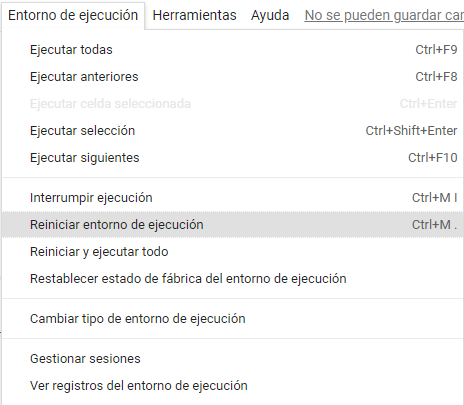

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

# Building an End-to-End Question-Answering System With BERT

In this notebook, we build a practical, end-to-end Question-Answering (QA) system with BERT in rougly 3 lines of code.  We will treat a corpus of text documents as a knowledge base to which we can ask questions and retrieve exact answers using [BERT](https://arxiv.org/abs/1810.04805). This goes beyond simplistic keyword searches.

For this example, we will use the [20 Newsgroup dataset](http://qwone.com/~jason/20Newsgroups/) as the text corpus.  As a collection of newsgroup postings which contains an abundance of opinions and debates, the corpus is not ideal as a knowledgebase.  It is better to use fact-based documents such as Wikipedia articles or even news articles.  However, this dataset will suffice for this example.

Let us begin by loading the dataset into an array using **scikit-learn** and importing *ktrain* modules.

In [ ]:
# load 20newsgroups datset into an array
from sklearn.datasets import fetch_20newsgroups
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', remove=remove)
docs = newsgroups_train.data +  newsgroups_test.data

In [ ]:
import ktrain
from ktrain import text

### STEP 1:  Index the Documents

We will first index the documents into a search engine that will be used to quickly retrieve documents that are likely to contain answers to a question. To do so, we must choose an index location, which must be a folder that does not already exist.

Since the newsgroup postings are small and fit in memory, we wil set `commit_every` to a large value to speed up the indexing process. This means results will not be written until the end.  If you experience issues, you can lower this value.

In [ ]:
INDEXDIR = '/tmp/myindex'

In [ ]:
text.SimpleQA.initialize_index(INDEXDIR)
text.SimpleQA.index_from_list(docs, INDEXDIR, commit_every=len(docs),
                              multisegment=True, procs=4, # these args speed up indexing
                               breakup_docs=True         # this slows indexing but speeds up answer retrieval
                              )

For documents sets that are too large to be loaded into a Python list, you can use `SimpleQA.index_from_folder`, which will crawl a folder and index all plain text documents (e.g.,, `.txt` files) by default.  If your documents are in formats like `.pdf`, `.docx`, or `.pptx`, you can supply the `use_text_extraction=True` argument to `index_from_folder`, which will use the [textract](https://textract.readthedocs.io/en/stable/) package to extract text from different file types and index this text into the search engine for answer rerieval.  You can also manually convert them to `.txt` files with the  `ktrain.text.textutils.extract_copy` or tools like [Apache Tika](https://tika.apache.org/) or [textract](https://textract.readthedocs.io/en/stable/).  

#### Speeding Up Indexing
By default, `index_from_list` and `index_from_folder` use a single processor (`procs=1`) with each processor using a maximum of 256MB of memory (`limitmb=256`) and merging results into a single segment (`multisegment=False`).  These values can be changed to speedup indexing as arguments to `index_from_list` or `index_from_folder`.  See the [whoosh documentation](https://whoosh.readthedocs.io/en/latest/batch.html) for more information on these parameters and how to use them to speedup indexing.  In this case, we've used `multisegment=True` and `procs=4`.

#### Speeding Up Answer Retrieval

Note that larger documents will cause inferences in STEP 3 (see below) to be very slow.  If your dataset consists of larger documents (e.g., long articles), we recommend breaking them up into pages (e.g., splitting the original PDF using something like `pdfseparate`) or splitting them into paragraphs (paragraphs are probably preferrable).  The latter can be done with *ktrain* using:
```python
ktrain.text.textutils.paragraph_tokenize(document, join_sentences=True)
```
If you supply `breakup_docs=True` in the cell above, this will be done automatically.  Note that `breakup_docs=True` will slightly **slow indexing** (i.e., STEP 1), but **speed up answer retrieval** (i.e., STEP 3 below).  A second way to speed up answer-retrieval is to increase `batch_size` in STEP 3 if using a GPU, which will be discussed later.


The above steps need to only be performed once. Once an index is already created, you can skip this step and proceed directly to **STEP 2** to begin using your system.

### STEP 2: Create a QA instance

Next, we create a QA instance.  This step will automatically download the BERT SQuAD model if it does not already exist on your system.

In [ ]:
qa = text.SimpleQA(INDEXDIR)

That's it!  In roughly **3 lines of code**, we have built an end-to-end QA system that can now be used to generate answers to questions.  Let's ask our system some questions.

### STEP 3:  Ask Questions

We will invoke the `ask` method to issue questions to the text corpus we indexed and retrieve answers.  We will also use the `qa.display` method to nicely display the top 5 results in this Jupyter notebook. The answers are inferred using a BERT model fine-tuned on the SQuAD dataset.  The model will comb through paragraphs and sentences to find candidate answers. By default, `ask` currently uses a `batch_size` of 8, but, if necessary, you can experiment with lowering it by setting the `batch_size` parameter.  On a CPU, for instance, you may want to try `batch_size=1`.

Note also that the 20 Newsgroup Dataset covers events in the early to mid 1990s, so references to recent events will not exist.

#### Space Question

In [ ]:
answers = qa.ask('When did the Cassini probe launch?')
qa.display_answers(answers[:5])

,Candidate Answer,Context,Confidence,Document Reference
0,in october of 1997,cassini is scheduled for launch aboard a titan iv / centaur in october of 1997 .,0.819032,59
1,"on january 26,1962","ranger 3, launched on january 26,1962 , was intended to land an instrument capsule on the surface of the moon, but problems during the launch caused the probe to miss the moon and head into solar orbit.",0.151230,8525
2,- 10 / 06 / 97,key scheduled dates for the cassini mission (vvejga trajectory)-------------------------------------------------------------10 / 06 / 97-titan iv / centaur launch 04 / 21 / 98-venus 1 gravity assist 06 / 20 / 99-venus 2 gravity assist 08 / 16 / 99-earth gravity assist 12 / 30 / 00-jupiter gravity assist 06 / 25 / 04-saturn arrival 01 / 09 / 05-titan probe release 01 / 30 / 05-titan probe entry 06 / 25 / 08-end of primary mission (schedule last updated 7 / 22 / 92) - 10 / 06 / 97,0.029694,59
3,* 98,"cassini * * * * * * * * * * * * * * * * * * 98 ,115 * * * *",0.000026,5356
4,the latter part of the 1990s,"scheduled for launch in the latter part of the 1990s , the craf and cassini missions are a collaborative project of nasa, the european space agency and the federal space agencies of germany and italy, as well as the united states air force and the department of energy.",0.000017,18684


As you can see, the top candidate answer indicates that the Cassini space probe was launched in October of 1997, which appears to be correct.  The correct answer will not always be the top answer, but it is in this case.  


The 20 Newsgroup dataset contains lots of posts discussing and debating religions like Christianity and Islam, as well.  Let's ask a question on this subject.

#### Religious Question

In [ ]:
answers = qa.ask('Who was Muhammad?')
qa.display_answers(answers[:5])

,Candidate Answer,Context,Confidence,Document Reference
0,the holy prophet of islam,"just a small reminder to all my muslim brothers, did _ ever _ the holy prophet of islam (muhammad pbuh), say to anyone who called himself a muslim :",0.762461,1278
1,the messenger of allah,"muhammad is the messenger of allah , and those who are with him are firm against the unbelievers and merciful among each other.",0.201865,4876
2,is the last prophet of islam,muhammad peace and blessings of allah be upon him (saw) is the last prophet of islam .,0.035121,4640
3,"either a liar, or he was crazy (a modern day mad mahdi) or he was actually who he said he was","the book says that muhammad was either a liar, or he was crazy (a modern day mad mahdi) or he was actually who he said he was .",0.000293,4934
4,[ mahound ' s,"muhammad ' s [ mahound ' s ] integrity is not really impugned in this part of the story, and there ' s no reason to think this was rushdie ' s intent : gibreel, as the archangel, produces the verses (divine and satanic), though he does not know their provenance.",0.000138,15852


Here, we see different views on who Muhammad, the founder of Islam, as debated and discussed in this document set.

Finally, the 20 Newsgroup dataset also contains many groups about computing hardware and software.  Let's ask a technical support question.

#### Technical Question

In [ ]:
answers = qa.ask('What causes computer images to be too dark?')
qa.display_answers(answers[:5])

,Candidate Answer,Context,Confidence,Document Reference
0,if your viewer does not do gamma correction,"if your viewer does not do gamma correction , then linear images will look too dark, and gamma corrected images will ok.",0.937990,13873
1,is gamma correction,"this, is gamma correction (or the lack of it).",0.045165,13873
2,so if you just dump your nice linear image out to a crt,"so if you just dump your nice linear image out to a crt , the image will look much too dark.",0.010337,13873
3,that small color details,"the algorithm achieves much of its compression by exploiting known limitations of the human eye, notably the fact that small color details are not perceived as well as small details of light and dark.",0.002115,16207
4,that small color details,"the algorithm achieves much of its compression by exploiting known limitations of the human eye, notably the fact that small color details are not perceived as well as small details of light and dark.",0.002115,6987


As you can see, a lack of *gamma correction* is the top answer.


### Using `SimpleQA` as a Simple Search Engine
Once an index is created, `SimpleQA` can also be used as a conventional search engine to perform keyword searches using the `search` method:

See the [whoosh documentation](https://whoosh.readthedocs.io/en/latest/querylang.html) for more information on query syntax.



# Answer Extraction

We are going to play around a little bit more with the idea of Question Answering. In particular, we are going to implement a system for Infomation Extraction based on the question answering model that we have used above.

Information Extraction is the task of, given a reference text, extracting specific pieces of information from it. For example, suppose you have a table (e.g., an Excel spreadsheet) that looks like the DataFrame below. (In this example, each document is a single sentence, but each row can potentially be an entire report with many paragraphs.)



In [ ]:
data = [
'Indeed, risk factors are sex, obesity, genetic factors and mechanical factors (3) .',
'There is a risk of Donald Trump running again in 2024.',
"""This risk was consistent across patients stratified by history of CVD, risk factors
but no CVD, and neither CVD nor risk factors.""",
"""Risk factors associated with subsequent death include older age, hypertension, diabetes,
ischemic heart disease, obesity and chronic lung disease; however, sometimes
there are no obvious risk factors .""",
'Three major risk factors for COVID-19 were sex (male), age (≥60), and severe pneumonia.',
'His speciality is medical risk assessments, and he is 30 years old.',
"""Results: A total of nine studies including 356 patients were included in this study,
the mean age was 52.4 years and 221 (62.1%) were male."""]

import pandas as pd
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(data, columns=['Text'])
df.head(10)

,Text
0,"Indeed, risk factors are sex, obesity, genetic factors and mechanical factors (3) ."
1,There is a risk of Donald Trump running again in 2024.
2,"This risk was consistent across patients stratified by history of CVD, risk factors \nbut no CVD, and neither CVD nor risk factors."
3,"Risk factors associated with subsequent death include older age, hypertension, diabetes, \nischemic heart disease, obesity and chronic lung disease; however, sometimes \nthere are no obvious risk factors ."
4,"Three major risk factors for COVID-19 were sex (male), age (≥60), and severe pneumonia."
5,"His speciality is medical risk assessments, and he is 30 years old."
6,"Results: A total of nine studies including 356 patients were included in this study, \nthe mean age was 52.4 years and 221 (62.1%) were male."


The dataset includes reports about the risk of different factors associated with COVID gathered from various medical studies. This is a toy example, but a real problem will potentially contain thousands of reports, several pages long each.

Let's pretend your boss wants you to extract both the reported risk factors from each document and the sample sizes for the reported studies. If you're going to make sense of the problem, you must read them all and summarize the findings. However, we can use the Question Answering system that we already have to "ask" those questions to the reports.

This can easily be accomplished with the AnswerExtractor in ktrain, a kind of universal information extractor based on a Question-Answering model.


In [ ]:
from ktrain.text.qa import AnswerExtractor
ae = AnswerExtractor()
df = ae.extract(df.Text.values, df, [('What are the risk factors?', 'Risk Factors'),
                                     ('How many individuals in sample?', 'Sample Size')])
df.head(10)

,Text,Risk Factors,Sample Size
0,"Indeed, risk factors are sex, obesity, genetic factors and mechanical factors (3) .","sex, obesity, genetic factors and mechanical factors",None
1,There is a risk of Donald Trump running again in 2024.,None,None
2,"This risk was consistent across patients stratified by history of CVD, risk factors \nbut no CVD, and neither CVD nor risk factors.",neither CVD nor risk factors,None
3,"Risk factors associated with subsequent death include older age, hypertension, diabetes, \nischemic heart disease, obesity and chronic lung disease; however, sometimes \nthere are no obvious risk factors .","older age, hypertension, diabetes, ischemic heart disease, obesity and chronic lung disease",None
4,"Three major risk factors for COVID-19 were sex (male), age (≥60), and severe pneumonia.","sex (male), age (≥60), and severe pneumonia",None
5,"His speciality is medical risk assessments, and he is 30 years old.",None,None
6,"Results: A total of nine studies including 356 patients were included in this study, \nthe mean age was 52.4 years and 221 (62.1%) were male.",None,356


In [ ]:
data = ["Closing price for Square on October 8th was $238.57, for details - https://finance.yahoo.com",
        """The film "The Many Saints of Newark" was released on 10/01/2021.""",
           "Release delayed until the 1st of October due to COVID-19",
           "Price of Bitcoin fell to forty thousand dollars",
           "Documentation can be found at: amaiya.github.io/causalnlp",
]
df = pd.DataFrame(data, columns=['Text'])
df = ae.extract(df.Text.values, df, [('What is the amount?', 'Amount'),
                                     ('What is the URL?', 'URL'),
                                     ('What is the date?', 'Date')])
df.head(10)

,Text,Amount,URL,Date
0,"Closing price for Square on October 8th was $238.57, for details - https://finance.yahoo.com",238.57,https://finance.yahoo.com,October 8th
1,"The film ""The Many Saints of Newark"" was released on 10/01/2021.",None,None,10/01/2021
2,Release delayed until the 1st of October due to COVID-19,None,None,1st of October
3,Price of Bitcoin fell to forty thousand dollars,forty thousand dollars,None,None
4,Documentation can be found at: amaiya.github.io/causalnlp,None,amaiya.github.io/causalnlp,None


In [ ]:
df = pd.DataFrame(docs[:25], columns=['Text'])
ae.extract(df.Text.values, df, [('What is the university?', 'University')])


,Text,University
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",None
1,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",None
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a computer store breifly and figured the opinions of somebody\nwho actually uses the machine daily might prove helpful).\n\n* how well does hellcats perform? ;)\n\nthanks a bunch in advance for any info - if you could email, i'll post a\nsummary (news reading time is at a premium with finals just around the\ncorner... :( )\n--\nTom Willis \ twillis@ecn.purdue.edu \ Purdue Electrical Engineering",Purdue Electrical Engineering
3,\nDo you have Weitek's address/phone number? I'd like to get some information\nabout this chip.\n,None
4,"From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n\n\nMy understanding is that the 'expected errors' are basically\nknown bugs in the warning system software - things are checked\nthat don't have the right values in yet because they aren't\nset till after launch, and suchlike. Rather than fix the code\nand possibly introduce new bugs, they just tell the crew\n'ok, if you see a warning no. 213 before liftoff, ignore it'.",None
5,"\n\n\n\n\nOf course. The term must be rigidly defined in any bill.\n\n\nI doubt she uses this term for that. You are using a quote allegedly\nfrom her, can you back it up?\n\n\n\n\nI read the article as presenting first an argument about weapons of mass\ndestruction (as commonly understood) and then switching to other topics.\nThe first point evidently was to show that not all weapons should be\nallowed, and then the later analysis was, given this understanding, to\nconsider another class.\n\n\n\n",None
6,"There were a few people who responded to my request for info on\ntreatment for astrocytomas through email, whom I couldn't thank\ndirectly b

Play around!

In [ ]:
qa.search(' "solar orbit" AND "battery power" ') # find documents that contain both these phrases

[{'rawtext': 'RANGER 5 , launched October 18 , 1962 and similar to RANGER 3 and 4 , lost all solar panel and battery power enroute and eventually missed the Moon and drifted off into solar orbit .',
  'reference': '8525'}]